![](https://i.imgur.com/eBRPvWB.png)

# Apply Sequence to Sequence Network with Attention to Generic Time Series

##  (Part I: Artificial Dataset)

Based on [Practical PyTorch: Translation with a Sequence to Sequence Network and Attention](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb)

# Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models, and [matplotlib](https://matplotlib.org/) for plotting training and visualizing attention outputs later. The rest are builtin Python libraries.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from core import train, evaluate

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
def show_attention(attentions, figsize=(20, 5), title=None):
    plt.style.use('seaborn-notebook')
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    ax.grid(visible=False)
    fig.colorbar(cax)
    # Set up axes
    ax.set_xticklabels([str(x) for x in range(0, attentions.shape[1]+1, 1)], rotation=90)
    ax.set_yticklabels([str(x) for x in range(0, attentions.shape[0]+1, 1)])
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.ylabel('Output')
    plt.xlabel('Input')
    if title:
        plt.title(title)
    plt.show()
    plt.close()
    plt.style.use('fivethirtyeight')

## Prepare Aritificial Sin Wave Dataset

In [3]:
N = 10000
MAX_LENGTH = 60
start = np.repeat(np.random.random((1, N)), MAX_LENGTH, axis=0)
series = np.sin(np.repeat(np.expand_dims(np.linspace(-2, 2, 60), 1), N, axis=1) * np.pi + start)

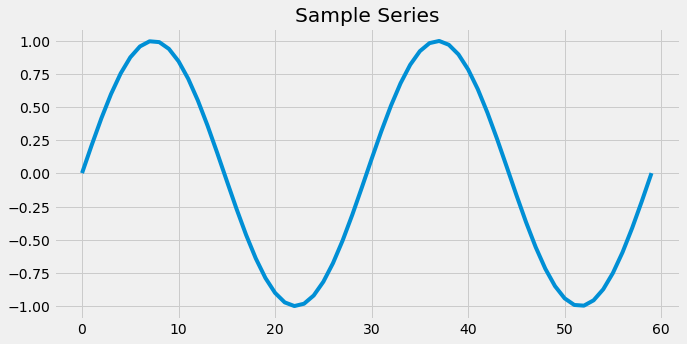

In [4]:
plt.plot(np.arange(60), series[:, 0])
plt.title("Sample Series")

In [5]:
encoder, decoder = train(series[:-20], series[-20:], 
      n_steps=200, attn_model="dot",
      hidden_size=16, n_layers=1, dropout=0, batch_size=128,
      elr=0.001, dlr=0.005, clip=50.0, print_every=20,
      teacher_forcing_ratio=lambda x: 1 if x < 20 else 0.5)

(20 10%) 0.2612
(40 20%) 0.1545
(60 30%) 0.0693
(80 40%) 0.0288
(100 50%) 0.0137
(120 60%) 0.0093
(140 70%) 0.0101
(160 80%) 0.0098
(180 90%) 0.0112
(200 100%) 0.0069


0.00954733124554


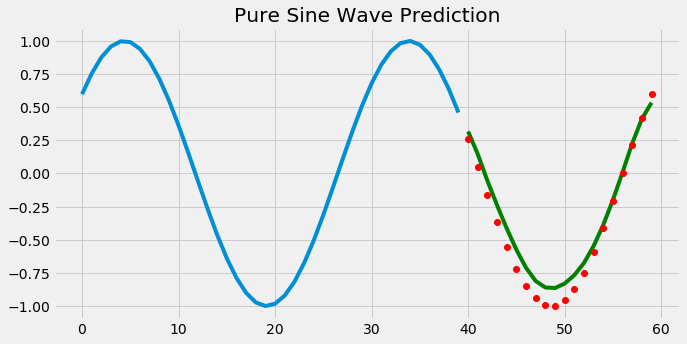

In [6]:
TARGET_IDX = series.shape[1] - 9
preds, attentions = evaluate(series[:-20, TARGET_IDX:(TARGET_IDX+1)], 20, encoder, decoder)
print(np.mean(np.square((preds.numpy() - series[-20:, TARGET_IDX:(TARGET_IDX+1)]))))
plt.plot(np.arange(40), series[:-20, TARGET_IDX])
plt.plot(np.arange(40, 60), preds[:, 0].numpy(), "g-")
plt.plot(np.arange(40, 60), series[-20:, TARGET_IDX], "ro")
plt.title("Pure Sine Wave Prediction")

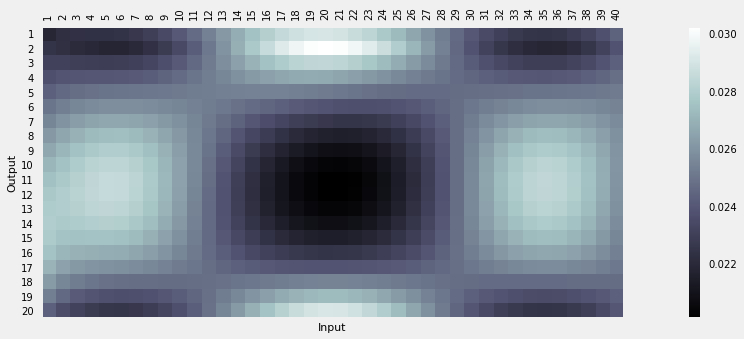

In [7]:
show_attention(attentions.numpy()[:, 0, :])

## Noisy Data

In [8]:
series_noisy = series + (np.random.random(series.shape)-0.5) / 2

In [9]:
encoder, decoder = train(series_noisy[:-20], series_noisy[-20:], 
      n_steps=200, attn_model="dot",
      hidden_size=32, n_layers=1, dropout=0, batch_size=128,
      elr=0.001, dlr=0.005, clip=50.0, print_every=20,
      teacher_forcing_ratio=lambda x: 1 if x < 10 else 0.5)

(20 10%) 0.2833
(40 20%) 0.1356
(60 30%) 0.0497
(80 40%) 0.0428
(100 50%) 0.0347
(120 60%) 0.0322
(140 70%) 0.0295
(160 80%) 0.0282
(180 90%) 0.0270
(200 100%) 0.0266


0.0169548523429


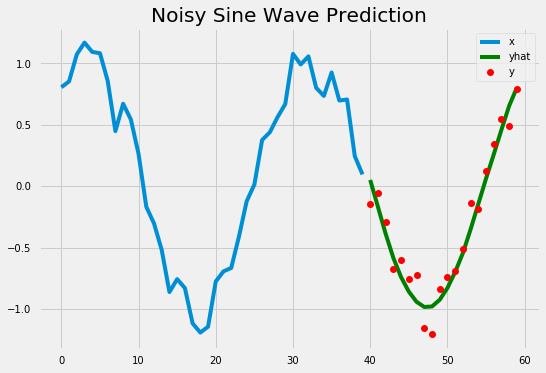

In [10]:
TARGET_IDX = series_noisy.shape[1] - 15
preds, attentions = evaluate(series_noisy[:-20, TARGET_IDX:(TARGET_IDX+1)], 20, encoder, decoder)
print(np.mean(np.square((preds.numpy() - series_noisy[-20:, TARGET_IDX:(TARGET_IDX+1)]))))
plt.plot(np.arange(40), series_noisy[:-20, TARGET_IDX], label="x")
plt.plot(np.arange(40, 60), preds[:, 0].numpy(), "g-", label="yhat")
plt.plot(np.arange(40, 60), series_noisy[-20:, TARGET_IDX], "ro", label="y")
plt.title("Noisy Sine Wave Prediction")
plt.legend(loc='best')

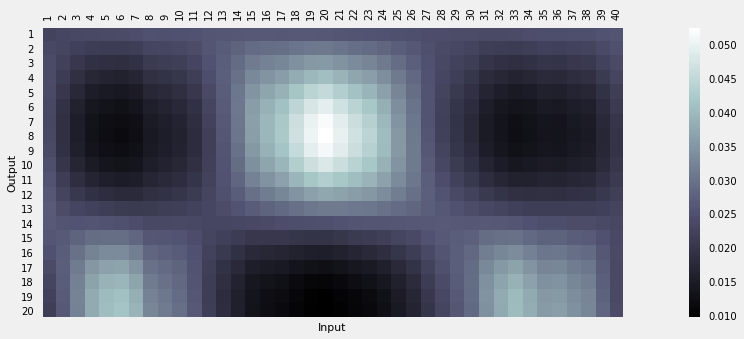

In [11]:
show_attention(attentions.numpy()[:, 0, :])

## More Advanced Dataset

### Transformed Series

In [12]:
N = 10000
MAX_LENGTH = 30
NOISE_LEVEL = 1/5
start = np.repeat(np.random.random((1, N)), MAX_LENGTH, axis=0)
raw_series = np.repeat(np.expand_dims(np.linspace(-2, 2, MAX_LENGTH ), 1), N, axis=1) + start
raw_series += (np.random.random(raw_series.shape)-0.5) * NOISE_LEVEL
transformed_series = np.sin(raw_series * np.pi)

In [13]:
encoder, decoder = train(transformed_series, raw_series, 
      n_steps=200, attn_model="general",
      hidden_size=128, n_layers=1, dropout=0, batch_size=32,
      elr=0.001, dlr=0.005, clip=50.0, print_every=20,
      teacher_forcing_ratio=lambda x: 1 if x < 10 else 0.5)

(20 10%) 0.3866
(40 20%) 0.0398
(60 30%) 0.0189
(80 40%) 0.0099
(100 50%) 0.0053
(120 60%) 0.0130
(140 70%) 0.0404
(160 80%) 0.0301
(180 90%) 0.0090
(200 100%) 0.0053


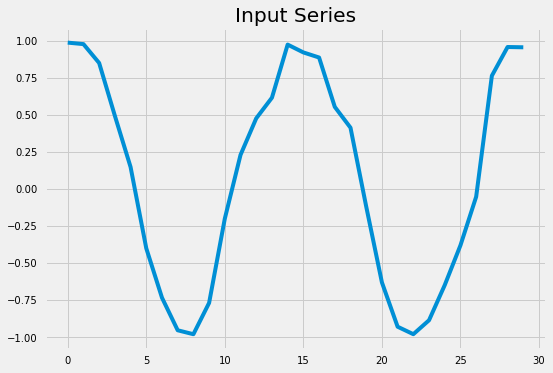

In [14]:
TARGET_IDX = 35
plt.plot(np.arange(transformed_series.shape[0]), transformed_series[:, TARGET_IDX])
plt.title("Input Series")

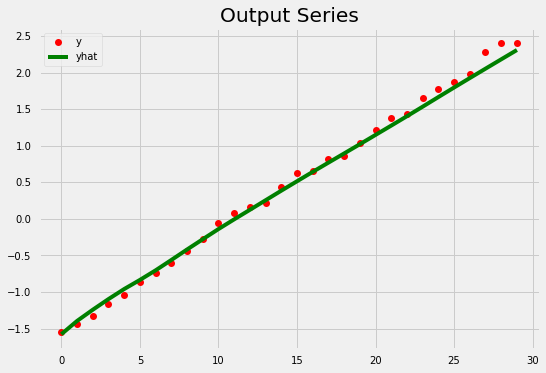

In [15]:
preds, attentions = evaluate(
    transformed_series[:, TARGET_IDX:(TARGET_IDX+1)], raw_series.shape[0], encoder, decoder)
plt.plot(np.arange(raw_series.shape[0]), raw_series[:, TARGET_IDX], "ro", label="y")
plt.plot(np.arange(raw_series.shape[0]), preds[:, 0].numpy(), "g-", label="yhat")
plt.title("Output Series")
plt.legend(loc='best')

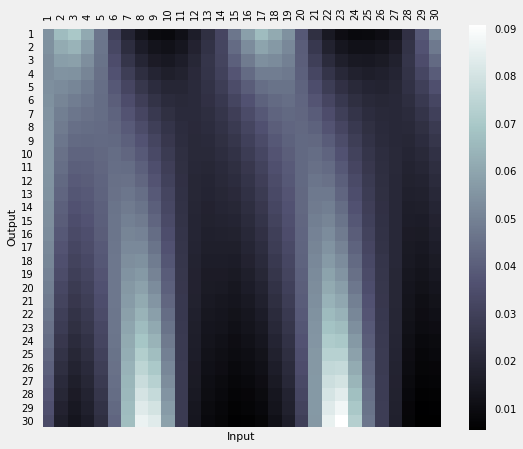

In [16]:
show_attention(attentions.numpy()[:, 0, :], figsize=(8, 7))

### Learn to remember permutation

In [17]:
N = 50000
MAX_LENGTH = 20
raw_series = np.random.uniform(-1, 1, (MAX_LENGTH, N))

In [18]:
USE_FIRST_N = np.random.randint(6, raw_series.shape[0]-8)
random_order = np.random.permutation(np.arange(USE_FIRST_N))
target_series = raw_series[random_order, :]
USE_FIRST_N

6

In [19]:
encoder, decoder = train(raw_series[:,:-20], target_series[:,:-20], 
      n_steps=5000, attn_model="general",
      hidden_size=16, n_layers=1, dropout=0, batch_size=32,
      elr=0.001, dlr=0.005, clip=50.0, print_every=500,
      teacher_forcing_ratio=lambda x: 1)

(500 10%) 0.2400
(1000 20%) 0.0875
(1500 30%) 0.0148
(2000 40%) 0.0037
(2500 50%) 0.0018
(3000 60%) 0.0011
(3500 70%) 0.0008
(4000 80%) 0.0007
(4500 90%) 0.0007
(5000 100%) 0.0006


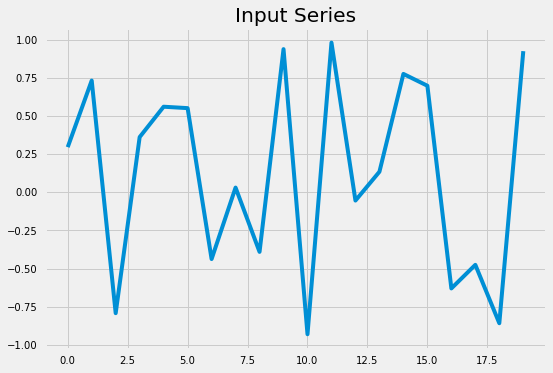

In [20]:
TARGET_IDX = raw_series.shape[1] - 2
plt.plot(np.arange(raw_series.shape[0]), raw_series[:, TARGET_IDX])
plt.title("Input Series")

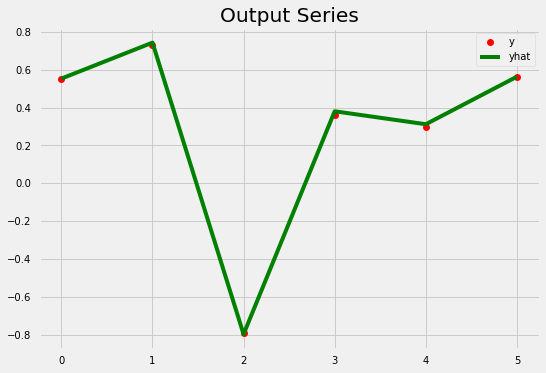

In [21]:
preds, attentions = evaluate(
    raw_series[:, TARGET_IDX:(TARGET_IDX+1)], target_series.shape[0], encoder, decoder)
plt.plot(np.arange(target_series.shape[0]), target_series[:, TARGET_IDX], "ro", label="y")
plt.plot(np.arange(target_series.shape[0]), preds[:, 0].numpy(), "g-", label="yhat")
plt.title("Output Series")
plt.legend(loc='best')

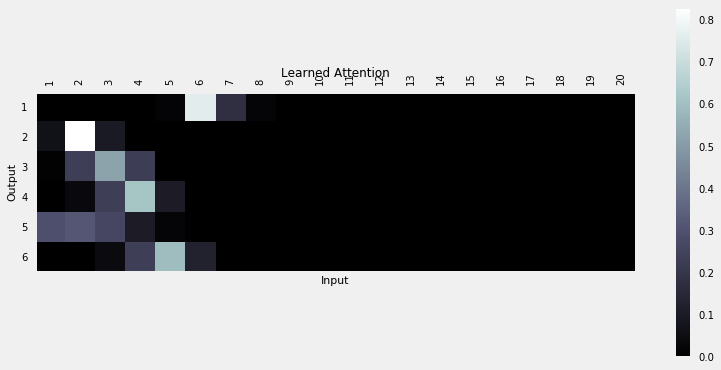

In [22]:
show_attention(attentions.numpy()[:, 0, :], figsize=(12, 6), title="Learned Attention")

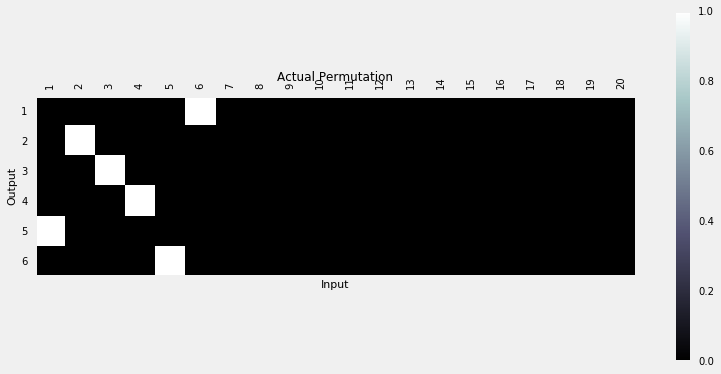

In [23]:
mat = np.zeros((random_order.shape[0], attentions.size()[2]))
mat[np.arange(random_order.shape[0]), random_order] = 1
show_attention(mat, figsize=(12, 6), title="Actual Permutation")

### Learn to remember combinations

In [24]:
N = 50000
MAX_LENGTH = 20
raw_series = np.random.uniform(-1, 1, (MAX_LENGTH, N))
# transformed_series = np.square(raw_series)
# transformed_series = raw_series

In [25]:
USE_FIRST_N = np.random.randint(6, raw_series.shape[0]-8)
random_order_1 = np.random.permutation(
    np.arange(USE_FIRST_N))
random_order_2 = np.random.permutation(
    np.arange(USE_FIRST_N))
target_series = (raw_series[random_order_1, :] + raw_series[random_order_2, :]) / 2
# target_series = raw_series
USE_FIRST_N

11

In [26]:
encoder, decoder = train(raw_series[:,:-20], target_series[:,:-20], 
      n_steps=5000, attn_model="general",
      hidden_size=16, n_layers=1, dropout=0, batch_size=32,
      elr=0.001, dlr=0.005, clip=50.0, print_every=500,
      teacher_forcing_ratio=lambda x: 1)

(500 10%) 0.1313
(1000 20%) 0.1180
(1500 30%) 0.0998
(2000 40%) 0.0622
(2500 50%) 0.0461
(3000 60%) 0.0395
(3500 70%) 0.0343
(4000 80%) 0.0310
(4500 90%) 0.0286
(5000 100%) 0.0266


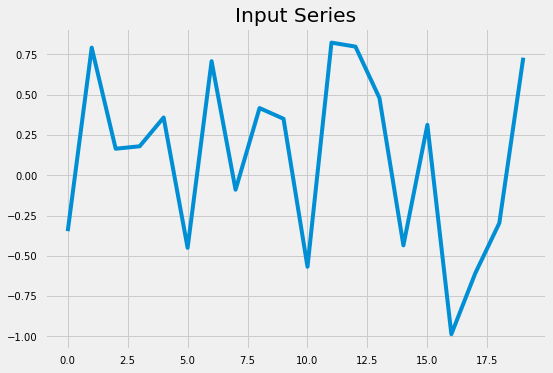

In [27]:
TARGET_IDX = raw_series.shape[1] - 15
plt.plot(np.arange(raw_series.shape[0]), raw_series[:, TARGET_IDX])
plt.title("Input Series")

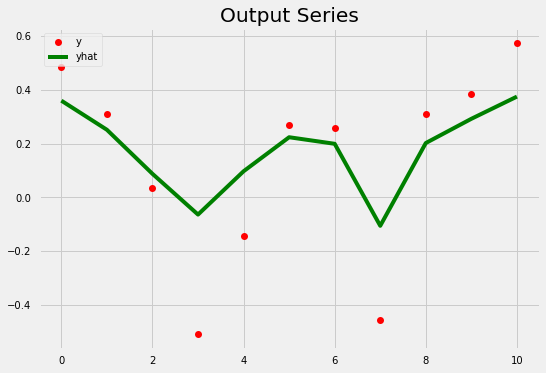

In [28]:
preds, attentions = evaluate(
    raw_series[:, TARGET_IDX:(TARGET_IDX+1)], target_series.shape[0], encoder, decoder)
plt.plot(np.arange(target_series.shape[0]), target_series[:, TARGET_IDX], "ro", label="y")
plt.plot(np.arange(target_series.shape[0]), preds[:, 0].numpy(), "g-", label="yhat")
plt.title("Output Series")
plt.legend(loc='best')

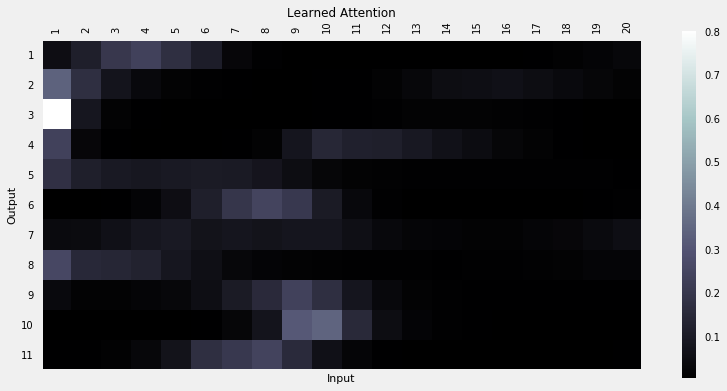

In [29]:
show_attention(attentions.numpy()[:, 0, :], figsize=(12, 6), title="Learned Attention")

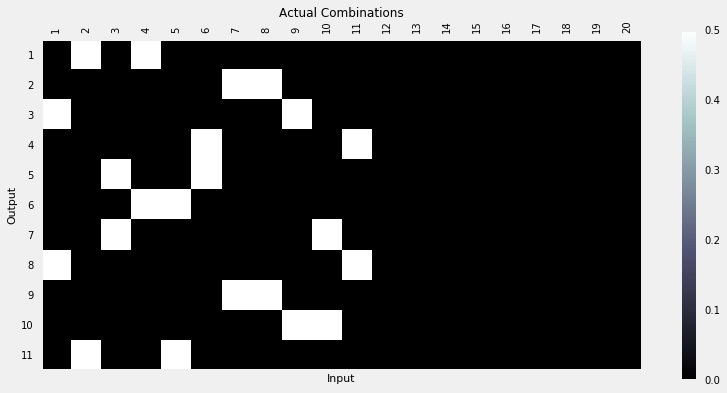

In [30]:
mat = np.zeros((random_order_1.shape[0], attentions.size()[2]))
mat[np.arange(random_order_1.shape[0]), random_order_1] = 0.5
mat[np.arange(random_order_1.shape[0]), random_order_2] += 0.5
show_attention(mat, figsize=(12, 6), title="Actual Combinations")